In [2]:
import cv2
import torch
import os
import random
import math
import glob 
import pathlib
import csv, PIL
import time, zipfile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

from tqdm import tqdm
from PIL import Image
from os import listdir
from torchvision import*

%matplotlib inline

In [3]:
basepath = %pwd
zipfile_path = basepath # + "/HIS_images_.zip"

In [4]:
import zipfile
with zipfile.ZipFile("vinbigdata-chest-xray-abnormalities-detection.zip") as a:
        a.extractall()

## DCM to np.array

In [4]:
import numpy as np 
import pydicom 
from pydicom.pixel_data_handlers.util import apply_voi_lut

import matplotlib.pyplot as plt
%matplotlib inline

In [32]:
def read_xray(path, voi_lut = True, fix_monochrome = True):
    dicom = pydicom.read_file(path)
    # VOI LUT (if available by DICOM device) is used to transform raw DICOM data to "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
    # depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
        
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    
    return data

In [33]:
pwd

'/home/Sean/iRail_Self_Study/CHS'

In [34]:
list_of_img = os.listdir("/home/Sean/iRail_Self_Study/CHS/train")
list_of_img[:5]

['000434271f63a053c4128a0ba6352c7f.dicom',
 '00053190460d56c53cc3e57321387478.dicom',
 '0005e8e3701dfb1dd93d53e2ff537b6e.dicom',
 '0006e0a85696f6bb578e84fafa9a5607.dicom',
 '0007d316f756b3fa0baea2ff514ce945.dicom']

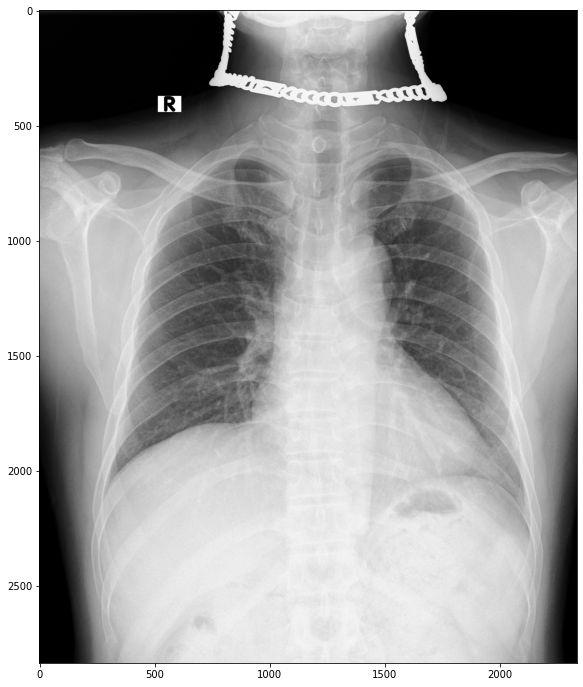

In [35]:
img = read_xray('/home/Sean/iRail_Self_Study/CHS/train/000434271f63a053c4128a0ba6352c7f.dicom')
plt.figure(figsize=(12,12))
plt.imshow(img, 'gray') # cmap='gray')

### if monochrome wasn't fixed

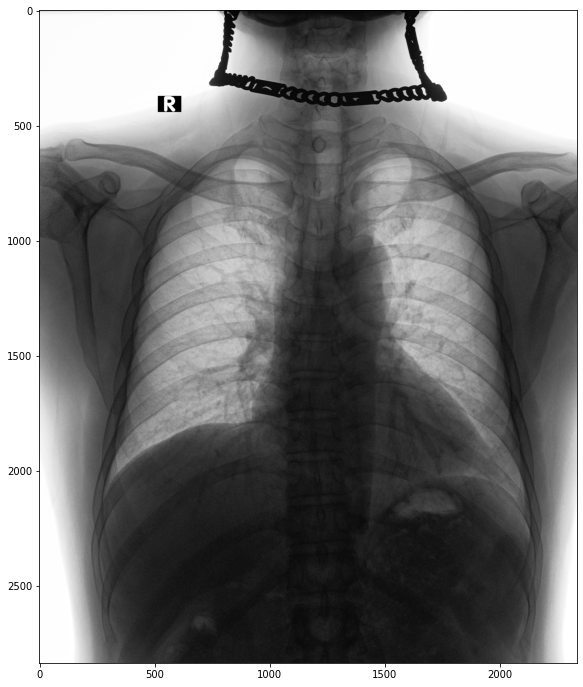

In [36]:
img = read_xray('/home/Sean/iRail_Self_Study/CHS/train/000434271f63a053c4128a0ba6352c7f.dicom', fix_monochrome=False)
plt.figure(figsize=(12,12))
plt.imshow(img, 'gray')

## Process and resize to image

In [14]:
! rm -rf kaggle/train

In [51]:
def resize(array, size, keep_ratio = False, resample = Image.LANCZOS):
    im = Image.fromarray(array)
    
    if keep_ratio:
        im.thumbnail((size, size), resample)
    else:
        im = im.resize((size, size), resample)
        
    return im

In [53]:
image_id = []
dim0 = []
dim1 = []

for split in ['train', 'test']:
    load_dir = f'/home/Sean/iRail_Self_Study/CHS/{split}/'
    save_dir = f'kaggle/{split}/'
    
    os.makedirs(save_dir, exist_ok=True)

    for file in tqdm(os.listdir(load_dir)):
        # set keep_ratio=True to have original aspect ratio
        xray = read_xray(load_dir + file)
        im = resize(xray, size=512)  
        im.save(save_dir + file.replace('dicom', 'png'))
        
        if split == 'train':
            image_id.append(file.replace('.dicom', ''))
            dim0.append(xray.shape[0])
            dim1.append(xray.shape[1])

  0%|          | 3/15000 [00:01<1:28:46,  2.82it/s]/usr/local/lib/python3.6/dist-packages/pydicom/pixel_data_handlers/pillow_handler.py:177: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  f"The (0028,0101) 'Bits Stored' value ({ds.BitsStored}-bit) "
  0%|          | 4/15000 [00:04<5:10:38,  1.24s/it]


KeyboardInterrupt: 

## CuPy Version

In [5]:
import cupy as cp

In [6]:
import torch 
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"'{device}' is avilable.")

'cuda' is avilable.


In [38]:
def read_xray(path, voi_lut = True, fix_monochrome = True):
    dicom = pydicom.read_file(path)
    # VOI LUT (if available by DICOM device) is used to transform raw DICOM data to "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
    # depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        #cp.cuda.Device(0).use()
        data = cp.amax(data) - data
        
    data = data - cp.min(data)
    data = data / cp.max(data)
    data = (data * 255).astype(cp.uint8)
    
    return data

In [39]:
def resize(array, size, keep_ratio = False, resample = Image.LANCZOS):
    im = Image.fromarray(array)
    
    if keep_ratio:
        im.thumbnail((size, size), resample)
    else:
        im = im.resize((size, size), resample)
        
    return im

In [35]:
! rm -rf kaggle/train

In [40]:
image_id = []
dim0 = []
dim1 = []

for split in ['train', 'test']:
    load_dir = f'/home/Sean/iRail_Self_Study/CHS/{split}/'
    save_dir = f'kaggle/{split}/'
    
    os.makedirs(save_dir, exist_ok=True)

    for file in tqdm(os.listdir(load_dir)):
        # set keep_ratio=True to have original aspect ratio
        xray = read_xray(load_dir + file)
        im = resize(xray, size=512)  
        im.save(save_dir + file.replace('dicom', 'png'))
        
        if split == 'train':
            image_id.append(file.replace('.dicom', ''))
            dim0.append(xray.shape[0])
            dim1.append(xray.shape[1])

100%|██████████| 3000/3000 [1:06:16<00:00,  1.33s/it]


In [41]:
df = pd.DataFrame.from_dict({'image_id': image_id, 'dim0': dim0, 'dim1': dim1})

df.to_csv('train_meta.csv', index=False)